# Giving geospatial context to a dataset

This a short analysis to illustrate if the distance to an art galley, museum or other cultural center might influence the price you pay per night for your Airbnb. The Airbnb dataset used for this exercise was downloaded from the website [Inside Airbnb](http://insideairbnb.com/) and the inventory of cultural sites was downloaded from [Seattle's Open Data Portal](https://data.seattle.gov/). Using these publicly accessible datasets we will show how to give some spatial context to a dataset while trying to answer the following questions:

1. Which are the most expensive neighborhoods in Seattle and what is their average distance to cultural sites?
2. Is there a correlation between price per night and the proximity to city's cultural sites?
3. Which are the most influential variables for predicting price per night?

## Data cleaning

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


In [2]:
# Import the listings and cultural sites datasets
listings = pd.read_csv('data/listings.csv')
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [13]:
# Data review
print('Column names\n', '----------\n', listings.columns)
print('Null values\n', '----------\n', listings.isna().sum().sort_values(ascending=False))
listings.dropna(subset=['price', 'latitude', 'longitude'], inplace=True)
tmp_price = listings['price'].str.split('$', expand=True)
listings['price_cleansed'] = tmp_price[1].str.replace(',', '').astype('float')

Column names
 ----------
 Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 

In [14]:
cultural = pd.read_csv('data/Seattle_Cultural_Space_Inventory.csv')
cultural.head(3)

,Name,Phone,URL,Square Feet Total,Neighborhood,Organization Type,Dominant Discipline,Year of Occupation,Rent vs Own,Age of Current Building,...,Constituency over 50% one race,Specific Demographics and Community,Organization Leadership,Organization Artists,Closed Date,Closed?,Address,Location,Latitude,Longitude
0,Bootstrap Music,NaN,NaN,NaN,NaN,NaN,Studios,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,Chinese Information and Service Center,NaN,NaN,NaN,NaN,NaN,Community Center,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,611 S Lane St Seattle WA 98104,"(47.596665, -122.325649)",47.596665,-122.325649
2,Gallery AXIS,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,308 1st Ave S,"(47.599804, -122.333995)",47.599804,-122.333995


In [15]:
# Data review
print('Column names\n', '----------\n', cultural.columns)
print('Null values\n', '----------\n', cultural.isna().sum().sort_values(ascending=False))
cultural.dropna(subset=['Latitude', 'Longitude'], inplace=True)

Column names
 ----------
 Index(['Name', 'Phone', 'URL', 'Square Feet Total', 'Neighborhood',
       'Organization Type', 'Dominant Discipline', 'Year of Occupation',
       'Rent vs Own', 'Age of Current Building', 'Length of Lease (Date)',
       ' Year Organization Founded', 'Number of Past Facilities',
       'Stages and Theaters', 'Stage & Theater Seats ', 'Gallery Space',
       'Gallery Square Feet', 'ADA Compliant', 'Available Parking',
       'Street Presence', 'Rental Space ', 'Alcohol Sales',
       'Organization Mission', 'Funded by A&C', 'Funded by 4Culture',
       'Stability Index (5=very stable, 1=very uncertain)',
       'Control Index (5=very in control, 1 = very out of control) ',
       'Constituency over 50% one race', 'Specific Demographics and Community',
       'Organization Leadership', 'Organization Artists', 'Closed Date',
       'Closed?', 'Address', 'Location', 'Latitude', 'Longitude'],
      dtype='object')
Null values
 ----------
 Organization Artists    

In [16]:
# create geodataframes and reproject them to UTM Zone 10N
gpd_airbnb = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings.longitude, listings.latitude), crs='EPSG:4326').to_crs('EPSG:32610')
gpd_cultural = gpd.GeoDataFrame(cultural, geometry=gpd.points_from_xy(cultural.Longitude, cultural.Latitude), crs='EPSG:4326').to_crs('EPSG:32610')

In [75]:
# join both datasets (listings, cultural) based on the closest cultural point
gpd_airbnb_cultural = gpd_airbnb.sjoin_nearest(gpd_cultural, distance_col="distance")
gpd_airbnb_cultural[['price_cleansed', 'distance']]

,price_cleansed,distance
0,85.0,510.173926
1,150.0,47.540641
3,100.0,262.710441
6,80.0,364.272624
9,150.0,224.897479
...,...,...
3793,109.0,504.657756
3732,65.0,347.697735
3733,125.0,65.873128
3781,55.0,183.272086


In [117]:
# correlation in Magnolia
mag = gpd_airbnb_cultural[gpd_airbnb_cultural['neighbourhood_group_cleansed'] == 'Magnolia']
mag[['price_cleansed', 'distance']].corr()

,price_cleansed,distance
price_cleansed,1.000000,-0.012854
distance,-0.012854,1.000000


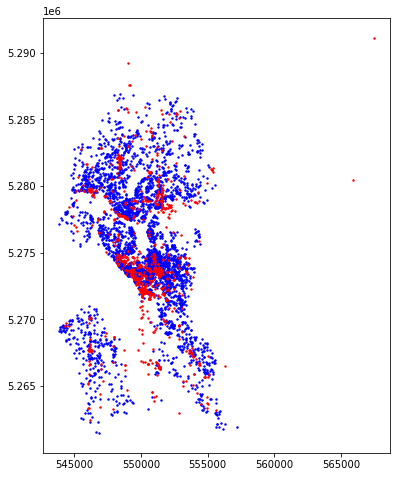

In [97]:
# Geographic plot
base = gpd_airbnb.plot(markersize=2, color="blue", figsize=(10,8))
gpd_cultural.plot(ax=base, markersize=2, color='red');

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64


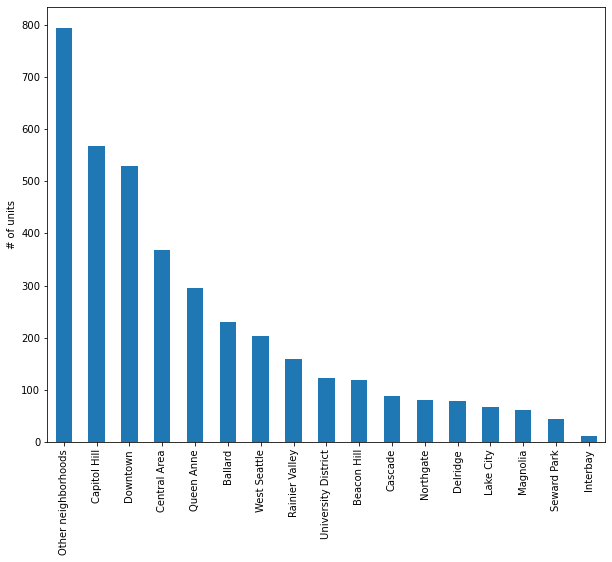

In [118]:
# number of listings per neighborhood group
print(listings['neighbourhood_group_cleansed'].value_counts())
listings['neighbourhood_group_cleansed'].value_counts().plot(kind='bar', figsize=(10,8), xlabel='', ylabel='# of units');

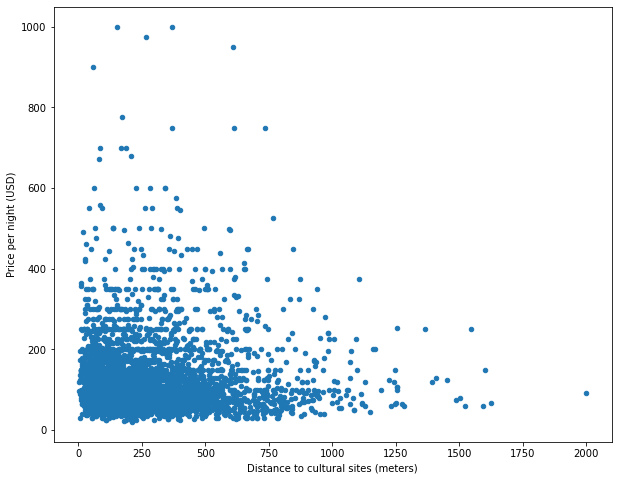

In [95]:
# Scatter plot of price and distance to cultural sites
gpd_airbnb_cultural.plot.scatter('distance', 'price_cleansed', figsize=(10,8),xlabel='Distance to cultural sites (meters)', ylabel='Price per night (USD)');

Other neighborhoods    836
Capitol Hill           583
Downtown               563
Name: neighbourhood_group_cleansed, dtype: int64


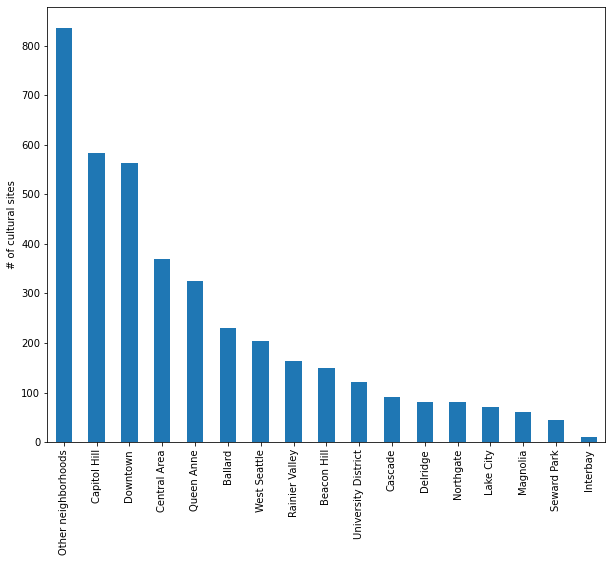

In [123]:
# number of cultiral sites by neighborhood
print(gpd_airbnb_cultural['neighbourhood_group_cleansed'].value_counts()[:3])
gpd_airbnb_cultural['neighbourhood_group_cleansed'].value_counts().plot.bar(figsize=(10,8), xlabel='', ylabel='# of cultural sites');

neighbourhood_group_cleansed
Magnolia      177.672131
Queen Anne    157.466258
Downtown      154.470693
Name: price_cleansed, dtype: float64


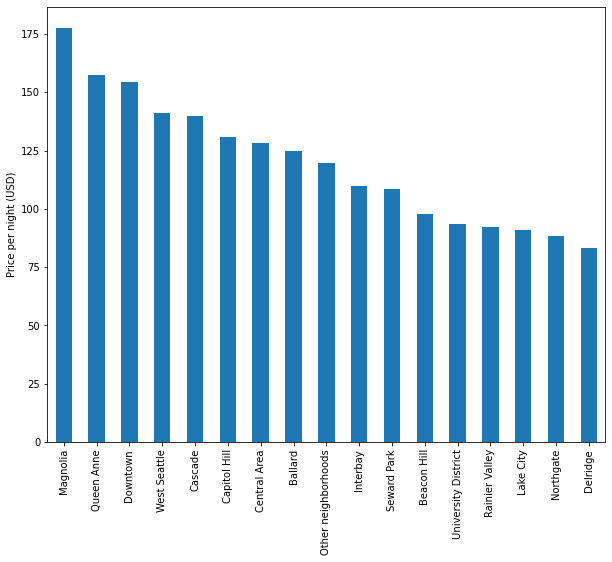

In [121]:
# average price-per-night by neighbouthoob
print(gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['price_cleansed'].mean().sort_values(ascending=False)[:3])
gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['price_cleansed'].mean().sort_values(ascending=False).plot.bar(figsize=(10,8), xlabel='', ylabel='Price per night (USD)');

neighbourhood_group_cleansed
Downtown                94.266945
University District    153.061736
Capitol Hill           216.085600
Name: distance, dtype: float64


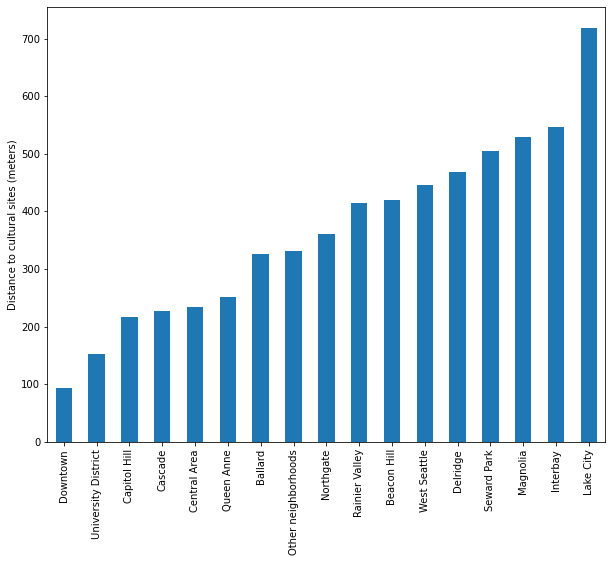

In [122]:
# average distance to cultural sites by neighbouthoob
print(gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['distance'].mean().sort_values()[:3])
gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['distance'].mean().sort_values().plot.bar(figsize=(10,8), xlabel='', ylabel='Distance to cultural sites (meters)');

## Is there a correlation between price per night and the proximity to city's cultural sites? 

In [119]:
# correlation between price and distance (<1000m) to cultural sites
# gpd_airbnb_cultural[gpd_airbnb_cultural['distance'] < 1000][['price_cleansed', 'distance']].corr()
# correlation between price and distance to cultural sites
gpd_airbnb_cultural[['price_cleansed', 'distance']].corr()

,price_cleansed,distance
price_cleansed,1.000000,-0.025377
distance,-0.025377,1.000000


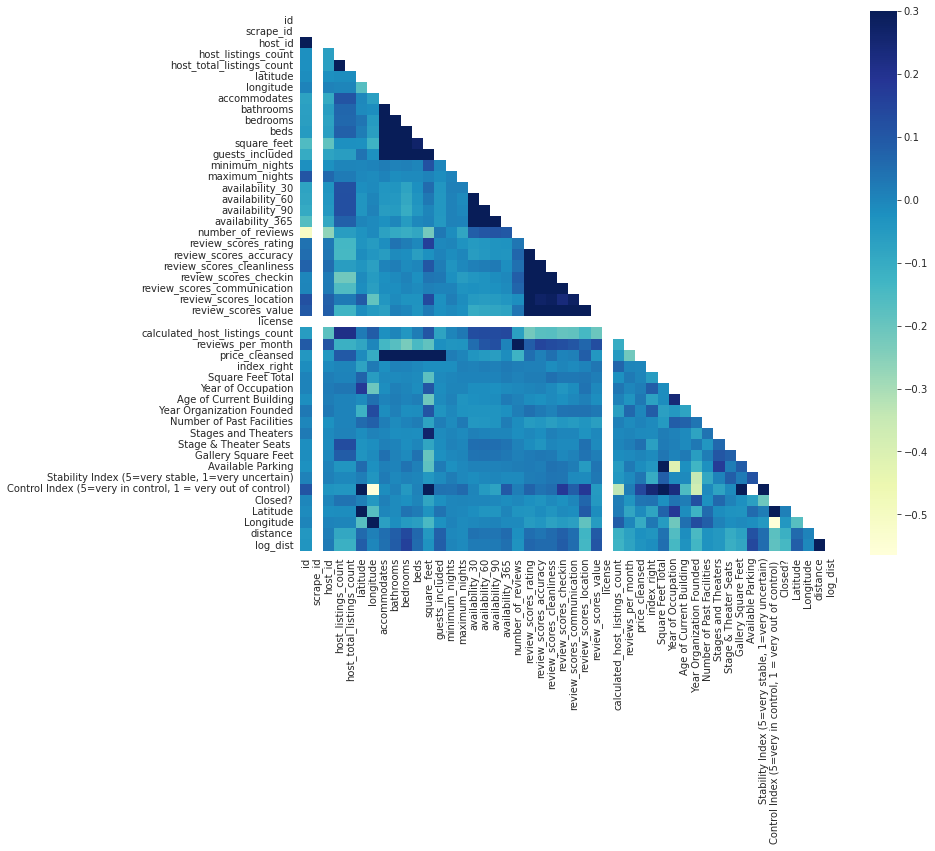

In [72]:
# correlation between variables using a heatmap
corr = gpd_airbnb_cultural.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(corr, mask=mask, vmax=0.3, square=True, cmap='YlGnBu');

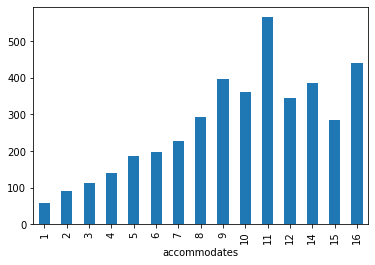

In [73]:
gpd_airbnb_cultural.groupby('accommodates')['price_cleansed'].mean().plot(kind='bar');

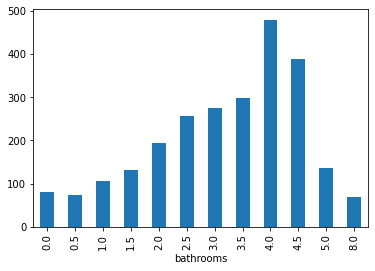

In [74]:
gpd_airbnb_cultural.groupby('bathrooms')['price_cleansed'].mean().plot(kind='bar');